### Web Page Conversion Analysis using A/B Test & Regression
#### The goal of this project is to help the e-commerce company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### IMPORT LIBRARIES

In [57]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

#### READ FILES

In [2]:
ab_data = pd.read_excel("C:\\Users\\josin\\OneDrive\\Desktop\\DA Portfolio Projects\\AB_Testing\\ab_data.xlsx")

In [3]:
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.557,control,old_page,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0
4,864975,2017-01-21 01:52:26.211,control,old_page,1


### Part I - Probability

In [4]:
ab_data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.557,control,old_page,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0
4,864975,2017-01-21 01:52:26.211,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.631,control,old_page,0
294474,945152,2017-01-12 00:51:57.078,control,old_page,0
294475,734608,2017-01-22 11:45:03.440,control,old_page,0
294476,697314,2017-01-15 01:20:28.957,control,old_page,0


In [5]:
ab_data.shape

(294478, 5)

In [6]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [7]:
ab_data.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [8]:
ab_data.user_id.nunique()

290584

In [9]:
ab_data.converted.mean()

0.11965919355605512

### The proportion of users converted

In [10]:
total_users = float(ab_data.shape[0])

In [11]:
users_converted = float(ab_data.query('converted==1')['user_id'].nunique())

In [12]:
proportion = (users_converted/ total_users)
print("The proportion of users converted is {0:.2%}".format(proportion))

The proportion of users converted is 11.94%


### The number of times the new_page and treatment don't line up (or match).

In [13]:
#group the dataframe by the group and landing page and count the entries for the resulting combinations
ab_data.groupby(["group", "landing_page"]).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [14]:
1965+ 1928

3893

In [19]:
ab_data.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")'
             )['user_id'].count()

3893

### Checking if there is missing values in the data

In [15]:
ab_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [16]:
ab_data.isnull().values.any()
#The result shows there is no missing values

False

#### For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page.

In [17]:
# Get all the indices of wrong entries

false_index = ab_data[((ab_data['group'] == 'treatment') == (ab_data['landing_page'] == 'new_page')) == False].index

print("Length of ab_data: ", len(ab_data))
print("Number of false rows in df: ",len(false_index))

#drop these indices out
ab_datanew = ab_data.drop(false_index)

print("Removed rows in ab_datanew: ",len(ab_data) - len(ab_datanew))

Length of ab_data:  294478
Number of false rows in df:  3893
Removed rows in ab_datanew:  3893


In [18]:
# Another Method
'''df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page")
                       or (group != "treatment" and landing_page == "new_page") 
                       or (group == "control" and landing_page != "old_page")
                       or (group != "control" and landing_page == "old_page")').index)'''

'df2 = df.drop(df.query(\'(group == "treatment" and landing_page != "new_page")\n                       or (group != "treatment" and landing_page == "new_page") \n                       or (group == "control" and landing_page != "old_page")\n                       or (group != "control" and landing_page == "old_page")\').index)'

#### Double Check all of the correct rows were removed - this should be 0

In [19]:
ab_datanew[((ab_datanew['group'] == 'treatment') == (ab_datanew['landing_page'] == 'new_page')) == False].shape[0]

0

#### Checking how many unique user_ids are in ab_datanew

In [20]:
ab_datanew['user_id'].nunique()

290584

#### Checking for duplicate user_id

In [21]:
ab_datanew[ab_datanew.duplicated(['user_id'], keep=False)]['user_id']
#User_id 773192 is repeated

1899    773192
2893    773192
Name: user_id, dtype: int64

In [22]:
ab_datanew[ab_datanew.duplicated(subset = ["user_id"], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.782,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.591,treatment,new_page,0


#### Removing one of the rows with a duplicate user_id, but keeping same dataframe 

In [23]:
ab_datanew = ab_datanew.drop(ab_datanew[(ab_datanew.user_id == 773192) & (ab_datanew['timestamp'] == '2017-01-09 05:37:58.782')].index)


In [24]:
ab_datanew[ab_datanew['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.591,treatment,new_page,0


#### Probability of an individual converting regardless of the page they receive

In [25]:
converted_users = float(ab_datanew.query('converted == 1')['user_id'].nunique())
converted_proportion = converted_users/float(ab_datanew.shape[0])
print("The probability of an individual converting regardless of the page they receive is {0:.2%}".format(converted_proportion))

The probability of an individual converting regardless of the page they receive is 11.96%


#### Probability of an individual in the control group converting to other page

In [26]:
converted_control_users = float(ab_datanew.query('converted == 1 and group == "control"')['user_id'].nunique())
control_users =float(ab_datanew.query('group == "control"')['user_id'].nunique())
control_converted_proportion = converted_control_users /control_users
print(" Probability of an individual in the control group converting to the other page is {0:.2%}".format(control_converted_proportion))

 Probability of an individual in the control group converting to the other page is 12.04%


#### Probability of an individual in the treatment group converting to other page

In [27]:
converted_treatment_users = float(ab_datanew.query('converted == 1 and group == "treatment"')['user_id'].nunique())
treatment_users =float(ab_datanew.query('group == "treatment"')['user_id'].nunique())
treatment_converted_proportion = converted_treatment_users /treatment_users
print(" Probability of an individual in the control group converting to the other page is {0:.2%}".format(treatment_converted_proportion))

 Probability of an individual in the control group converting to the other page is 11.88%


#### Probability of an individual received the new page

In [28]:
new_page_users = float(ab_datanew.query('landing_page == "new_page"')['user_id'].nunique())
new_page_proportion = new_page_users/float(ab_datanew.shape[0])
print("The probability that an individual received the new page is {0:.2%}".format(new_page_proportion))

The probability that an individual received the new page is 50.01%


In [29]:
new_page_converted_users = float(ab_datanew.query('converted == 1 and  landing_page == "new_page"')['user_id'].nunique())
new_page_users =float(ab_datanew.query('landing_page == "new_page"')['user_id'].nunique())

print(" If an individual was in new landing page, the probability that he converted to old page is {0:.2%}".format(new_page_converted_users /new_page_users))

 If an individual was in new landing page, the probability that he converted to old page is 11.88%


In [30]:
old_page_converted_users = float(ab_datanew.query('converted == 1 and  landing_page == "old_page"')['user_id'].nunique())
old_page_users =float(ab_datanew.query('landing_page == "old_page"')['user_id'].nunique())

print(" If an individual was in old landing page, the probability that he converted to new page is {0:.2%}".format(old_page_converted_users /old_page_users))

 If an individual was in old landing page, the probability that he converted to new page is 12.04%


#### The probability of an individual converting regardless of the page they receive is 11.96%, Given that an individual was in the control group, the probability they converted is 12.04% Given that an individual was in the treatment group, the probability they converted is 11.88%. The probablity users converted in both control and treatment group are pretty similar to each other and probability of an individual converting regardless of the page they receive. therefore, there is no evidence that one page leads to more conversions.

### Part II - A/B Test

#### Null hypothese is H0: p_new - p_old <= 0 
#### Alternative hypothese is H1: p_new - p_old > 0

 Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.


Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

Here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

The convert rate for $p_{new}$ under the null

In [58]:
# Compute converted success rate, which equals to the converted success rate regardless of page
p_new = round(float(ab_datanew.query('converted == 1')['user_id'].nunique())/float(ab_datanew['user_id'].nunique()),4)

# Display converted success rate
p_new

0.1196

The convert rate for  $p_{old}$  under the null

In [59]:
# Compute old converted success rate, which equals to the converted success rate regardless of page
p_old = round(float(ab_datanew.query('converted == 1')['user_id'].nunique())/float(ab_datanew['user_id'].nunique()),4)

# Display old converted success rate
p_old

0.1196

In [60]:

#Compute the number of unique users who has new page using df2 dataframe
n_new = ab_datanew.query('landing_page == "new_page"')['user_id'].nunique()

#display the number of unique users who has new page
n_new

145310

In [61]:

#Compute the number of unique users who has old page  using df2 dataframe
n_old = ab_datanew.query('landing_page == "old_page"')['user_id'].nunique() 
#display the number of unique users who has new page
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in new_page_converted.

In [64]:

#Simulate  n_new  transactions with a convert rate of  p_new  under the null
new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))

#Display new_page_converted
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

In [65]:
new_page_converted.sum()

17413

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in old_page_converted.

In [66]:

#Simulate  n_old  transactions with a convert rate of  p_old  under the null
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = [p_old, (1-p_old)])

#Display old_page_converted
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

In [67]:
old_page_converted.sum()

17587

$p_{new}$ - $p_{old}$ for simulated values

In [68]:
#Compute the probablity of new page converted rate
new_page_converted.mean()

0.1198334595003785

In [69]:
#Compute the probablity of old page converted rate
old_page_converted.mean()

0.12106089183198646

In [70]:

#Find  pnewpnew  -  poldpold  for your simulated values from part (e) and (f).
new_page_converted.mean() - old_page_converted.mean()

-0.00122743233160795

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts a. through g. above. Store all 10,000 values in p_diffs.

In [71]:
#creating the sampling distribution with 10000 simulations of the steps before
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
    old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = (p_old, 1-p_old))
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([1.300e+01, 1.740e+02, 8.330e+02, 2.372e+03, 3.315e+03, 2.270e+03,
        8.390e+02, 1.670e+02, 1.500e+01, 2.000e+00]),
 array([-0.00458556, -0.0035642 , -0.00254285, -0.00152149, -0.00050014,
         0.00052122,  0.00154257,  0.00256393,  0.00358528,  0.00460664,
         0.00562799]),
 <BarContainer object of 10 artists>)

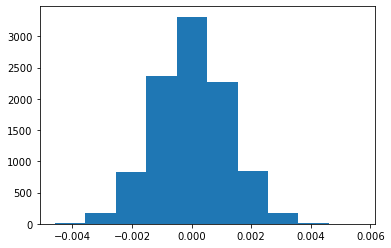

In [72]:
plt.hist(p_diffs)

In [74]:
p_actual_old = ab_datanew.query("group == 'control'").converted.mean()
p_actual_new = ab_datanew.query("group == 'treatment'").converted.mean()
actual_diff = p_actual_new - p_actual_old
print("Number of converted persons in control group: ",converted_control_users, "| p_old: ", p_actual_old)
print("Number of converted persons in treatment group: ",converted_treatment_users, "| p_new: ", p_actual_new)
print("Actual difference: ", actual_diff)

Number of converted persons in control group:  17489.0 | p_old:  0.1203863045004612
Number of converted persons in treatment group:  17264.0 | p_new:  0.11880806551510564
Actual difference:  -0.0015782389853555567


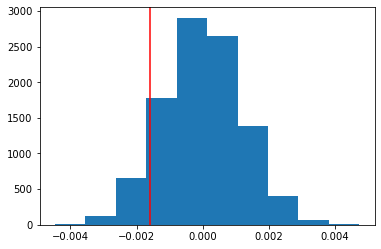

In [75]:
p_diffs = np.array(p_diffs)
#calcualte the null_vals based on the std of the p_diffs array
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(actual_diff, color = 'r')

In [76]:
#actual difference observed
(null_vals > actual_diff).mean()

0.9039

The p-value calculated in part j is 0.9044 t>he probability of observing your data or something more extreme in favor of the alternative given the null hypothesis is true. If the p-value is less than your Type I error threshold, then you have evidence to reject the null and choose the alternative. Otherwise, you fail to reject the null hypothesis. In this case, since p-value is greater than the alpha, we did not reject the null. There is not significant evidence that the new page generates more traffic.

the p-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct. source:https://en.wikipedia.org/wiki/P-value

the p-value is the probability of obtaining results as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. The p-value is used as an alternative to rejection points to provide the smallest level of significance at which the null hypothesis would be rejected. A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis. source:https://www.investopedia.com/terms/p/p-value.asp


Type I error rate of 5%, and Pold > Alpha, we fail to reject the null. Therefore, the data show, with a type I error rate of 0.05, that the old page has higher probablity of convert rate than new page.

P-Value: The probability of observing our statistic or a more extreme statistic from the null hypothesis.

 We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [77]:

#Import regression model library
import statsmodels.api as sm

In [80]:
convert_old = ab_datanew.query("group == 'control'").converted.sum()
convert_new = ab_datanew.query("group == 'treatment'").converted.sum()
n_old = ab_datanew.query("landing_page == 'old_page'").count()[0]
n_new = ab_datanew.query("landing_page == 'new_page'").count()[0]

In [84]:
from scipy.stats import norm

#calculate z-test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")

#calculate the critical z_term
z_critical=norm.ppf(1-(0.05))
print("Z-Score: ",z_score, "\nCritical Z-Score: ", z_critical, "\nP-Value: ", p_value)

Z-Score:  1.3109241984234394 
Critical Z-Score:  1.6448536269514722 
P-Value:  0.9050583127590245


Since the z-score of 1.3109241984234394 does not exceed the critical value of 1.6448536269514722,

we fail to reject the null hypothesis that old page users has a better or equal converted rate than old page users.

Therefore, the converted rate for new page and old page have no difference.

This result is the same as parts J. and K. result.

A Z-score is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean. source:https://www.investopedia.com/terms/z/zscore.asp

A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis. source:https://www.simplypsychology.org/p-value.html

A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis. You should note that you cannot accept the null hypothesis, we can only reject the null or fail to reject it. source:https://www.simplypsychology.org/p-value.html

Since the z-score of 1.3109241984234394 does not exceed the critical value of 1.959963984540054, we fail to reject the null hypothesis that old page users has a better or equal converted rate than old page users. Therefore, the converted rate for new page and old page have no difference. This result is the same as parts J. and K. result.


### Part III - A regression approach
1. In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.


a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression, due to the fact that response variable is categorical variable. logistic regression is multiple regression but with an outcome variable that is a categorical variable and predictor variables that are continuous

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [85]:
#load data
ab_data_log = ab_datanew.copy()
ab_data_log.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.557,control,old_page,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0
4,864975,2017-01-21 01:52:26.211,control,old_page,1


In [86]:
#add intercept
ab_data_log["intercept"] = 1
#get dummies and rename
ab_data_log = ab_data_log.join(pd.get_dummies(ab_data_log['group']))
ab_data_log.rename(columns = {"treatment": "ab_page"}, inplace=True)

In [87]:
ab_data_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.557,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.211,control,old_page,1,1,1,0


In [88]:
y = ab_data_log["converted"]
x = ab_data_log[["intercept", "ab_page"]]

#load model
log_mod = sm.Logit(y,x)

#fit model
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [90]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:28:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


e. What is the p-value associated with ab_page? Why does it differ from the value you found in the Part II?

Hint: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the Part II?

The p-value associated with ab_page is 0.190. The null in c-e part is that there is no difference between the treatment and control group. Alternative hypotheses is that there is difference between between the treatment and control group

Part II assumes the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, compared to question c-e,they have different explainory varibale or factor for the result.

f. Now, I am considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into regression model. Are there any disadvantages to adding additional terms into regression model?

Other factor can be the time(timestamp variable). We can check if the converted rate depends on certain time of the day or certain day when user browerse the website. For timestamp variable, we can further convert time as categorical variable which includes "Morning, afternoon, and evening", or "weekday and weekend". Disadavantage for adding additional terms into regression model is that it will make interpretate the model more complex and also, if new terms are dependable variable with the exisiting explanatory term, we need to add higher order term to help predict the result better.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows. Here are the docs for joining tables.

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy varaibles. Provide the statistical output as well as a written response to answer this question.

In [98]:
countries = pd.read_csv("C:\\Users\\josin\\OneDrive\\Desktop\\DA Portfolio Projects\\AB_Testing\\countries.csv")

In [99]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [102]:
#Join ab dataset with country dataset
ab_data_full= ab_data_log.merge(countries, on ='user_id', how='left')
ab_data_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.557,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.160,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.211,control,old_page,1,1,1,0,US


In [103]:
ab_data_full = ab_data_full.join(pd.get_dummies(ab_data_full['country']))
ab_data_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.557,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.160,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.211,control,old_page,1,1,1,0,US,0,0,1


In [104]:

y = ab_data_full["converted"]
x = ab_data_full[["intercept", "ab_page", "CA", "UK"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:               2.323e-05
Time:                        15:36:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

#### Based on the country-features p-values we can say, that these features also doens't have a significant impact on the coversion rate.

In [105]:
print("ab_page reciprocal exponential: ", 1/np.exp(-0.0149), "-", "A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant\n"
      "\nCA reciprocal exponential: ", 1/np.exp(-0.0408), "-", "A conversion is 1.042 times less likely, if the user lives in CA and not the US.\n"
      "\nUK exponential: ",np.exp(0.0099),"-", "A conversion is 1.00995 times more likely, if the user lives in UK and not the US.")

ab_page reciprocal exponential:  1.0150115583846535 - A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant

CA reciprocal exponential:  1.0416437559600236 - A conversion is 1.042 times less likely, if the user lives in CA and not the US.

UK exponential:  1.0099491671175422 - A conversion is 1.00995 times more likely, if the user lives in UK and not the US.


In [106]:
ab_data_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.557,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.160,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.211,control,old_page,1,1,1,0,US,0,0,1


In [107]:
#create the interaction higher order term for the ab_page and country columns
ab_data_full["CA_page"], ab_data_full["UK_page"] = ab_data_full["CA"] * ab_data_full["ab_page"], ab_data_full["UK"] * ab_data_full["ab_page"]

In [108]:
ab_data_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,CA_page,UK_page
0,851104,2017-01-21 22:11:48.557,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.211,control,old_page,1,1,1,0,US,0,0,1,0,0


In [109]:
y = ab_data_full["converted"]
x = ab_data_full[["intercept", "ab_page", "CA", "UK", "CA_page", "UK_page"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary() #result

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 12 Nov 2021   Pseudo R-squ.:               3.482e-05
Time:                        15:40:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

#### Based on these results, we can see that the p_values for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.

## Final Conclusion
The test conditions and the amount of data were ideal, there were not any missing or unconsistent data. The users have equal chance to get the old or the new page so both of the groups had similar size.

As a conclusion I can say that there is no evidence that the new page would work better that the old page, so we fail to reject the null hypothesis. Moreover, there is a chance, that the old page actually works better. The p-value of ab_page has a little increased in the last model, while the countries have have roughly similar results. So, we could not even say that the countries could play a significant role as an additional factor in predicting the user preferences.

The next steps could be to include other factors to our model to find out why the new page performed so poorly. As I mentioned, age could be a good factor to make another analysis. Maybe this could also mark the guidlines to create a better new page. However, the most important thing I would recommend the company is to improve their new page, after that we can make another test.